In [342]:
using Flux

In [1]:
using Random
using Statistics
using Plots

In [35]:
using NMF

In [2]:
using FFTW
using STFT
using WAV

6.108973194597674

In [260]:
# Generate notes for fake data set
sample_rate = 44000. / 16. # 16th reduction from typical sample rate
t = range(0, 2, step=1/sample_rate)
f = 100 #Hz

ceiling = 0.98 # ensures amplitude normalization in slightly under 1 to avoid speaker clipping issues
normalized(y) =  y ./ maximum(abs.(y)) .* ceiling

Random.seed!(314)

function make_note(t, f₀; N=10, delay=0)
    ϕ = 0#rand()*2π
    y = sum(exp.(-n*t).*sin.(2π*f₀*t*n .+ ϕ)/n for n ∈ 1:N) #N is number of harmonics
    if delay != 0
        y = delay_note(y, t, delay)
    end
    return normalized(y)
end

function delay_note(y, t, delay)
    index = findfirst(t .>= delay)
    z = copy(y)
    z[index:end] = y[1:end-index+1]
    z[1:index-1] .= 0
    return z
end

y = make_note(t, f)

5501-element Vector{Float64}:
  0.0
  0.98
  0.8145574992147147
  0.6769193855087904
  0.7288050982190868
  0.5569161822890482
  0.5381373750799182
  0.4806806240505409
  0.3596038882954261
  0.35359317076706304
  ⋮
 -0.07560050449559941
 -0.08043471962224685
 -0.08132135999502178
 -0.07783835061045388
 -0.06976977130899457
 -0.05721354464578726
 -0.04068149605516836
 -0.021147984693998333
  6.251188120037251e-16

In [1]:
plot(t,y,xlim=(0,1.1))

UndefVarError: UndefVarError: plot not defined

In [247]:
wavplay(y, sample_rate)

In [261]:
function make_chord(t,notes)
    y = sum(make_note(t,note) for note ∈ notes)
    return normalized(y)
end

function arp_chord(t,notes, delays)
    y = sum(make_note(t,note,delay=delay) for (note,delay) ∈ zip(notes,delays))
    return normalized(y)
end

notes = 100*[2,3,5]/2 # fundimental of 100Hz, and an open major chord in the ratio 2:3:5
delays = [0, 0.2, 0.4] #play each note one after another
y = arp_chord(t,notes,delays)

5501-element Vector{Float64}:
  0.0
  0.5451680479257096
  0.4531333895613609
  0.3765661428580593
  0.4054298497085761
  0.3098090897517949
  0.2993625533552902
  0.2673997117238217
  0.2000454589882779
  0.19670173333361413
  ⋮
  0.031723788356495565
 -0.013256513680870833
 -0.06703128580678985
 -0.11863925158399652
 -0.15805269113762282
 -0.17472644278595512
 -0.15706801699699177
 -0.09620069285212447
 -6.075416887442773e-14

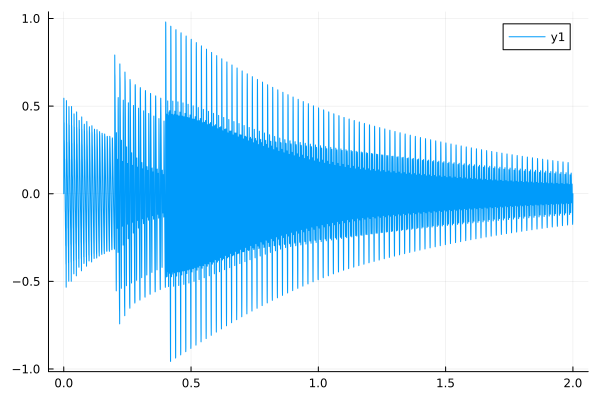

In [262]:
plot(t,y)
#plot!(xlim=(0,1.1))

In [264]:
wavplay(y, sample_rate)

In [265]:
function hann(N::Int)
    N = N - N % 2 #makes sure N even
    n = 0:N
    return @. sin(π*n/N)^2
end

N = sample_rate÷2
T = maximum(t)
w = 250          # window width
hop = w÷2 - 1   # number of samples to hop over
window = hann(w) 
Y = stft(y, window, hop)
nfreqs, ntimes = size(Y)
freqs = range(0, N, nfreqs)
times = range(0, T, ntimes)

# N = maximum frequency
# T = end of time interval
# t0 = start of time interval
function plotSTFT(Y, t0=0)

    Z = abs.(Y) .* (2/N)

    heatmap(times, freqs, Z)
    plot!(xlabel = "time (s)", ylabel = "frequency (Hz)")
end

plotSTFT (generic function with 4 methods)

In [17]:

#Y = stft(sin.(2π* 100*t), window, hop)

101×26 Matrix{ComplexF64}:
 -0.0481724+0.0im          0.0526166+0.0im         …   0.0481724+0.0im
 -0.0545982+0.0183031im    0.0590501+0.0174346im       0.0539994+0.0200006im
 -0.0783429+0.0447113im    0.0826914+0.0432352im       0.0753963+0.0495187im
  -0.139594+0.0963551im     0.143057+0.0954099im        0.129958+0.109003im
  -0.316299+0.231195im      0.314894+0.236053im         0.284997+0.268836im
   -1.05223+0.769126im       1.01979+0.813811im    …    0.919675+0.923543im
   -11.6164+8.29109im        10.9785+9.12063im            9.8667+10.3117im
    38.6853-26.732im         -35.683-30.6235im            -31.96-34.4922im
   -30.3538+20.2742im         27.329+24.1986im           24.3921+27.1555im
    3.64498-2.35637im         -3.202-2.92932im          -2.84746-3.27573im
           ⋮                                       ⋱            ⋮
  8.9449e-6+8.74123e-6im  5.16037e-6-1.1543e-5im      6.33563e-6-1.07833e-5im
 8.31857e-6+7.72772e-6im  5.19358e-6-1.01223e-5im      6.2958e-6-9.44876e-6i

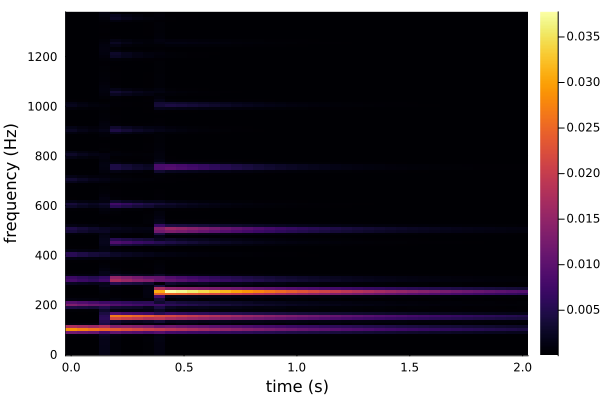

In [266]:
plotSTFT(Y)

In [267]:
r = 3
factorization = nnmf(abs.(Y), r; alg=:cd, maxiter=200, tol=1.0e-4)
W = factorization.W
H = factorization.H
@show factorization.converged, factorization.niters

(factorization.converged, factorization.niters) = (true, 130)


(true, 130)

In [213]:
#plot([h for h ∈ eachrow(H)])

In [186]:
#plot(collect(eachcol(W)), layout=(k,1))
#plot!(xlabel="frequency (Hz)")

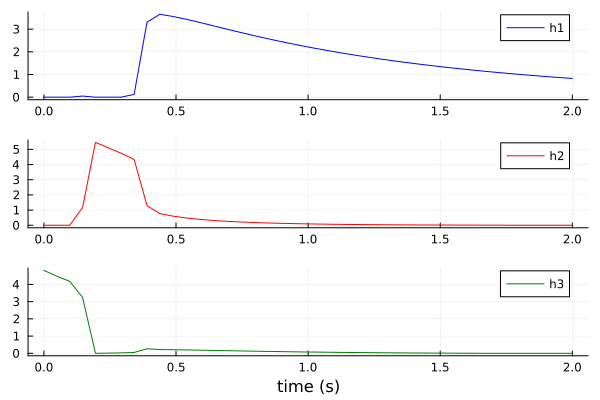

In [268]:
p1 = plot(times,H[1,:], color=:blue, label = "h1")
p2 = plot(times,H[2,:], color=:red, label = "h2")
p3 = plot(times,H[3,:], color=:green, label = "h3", xlabel = "time (s)")
plot(p1,p2,p3, layout=(k,1))

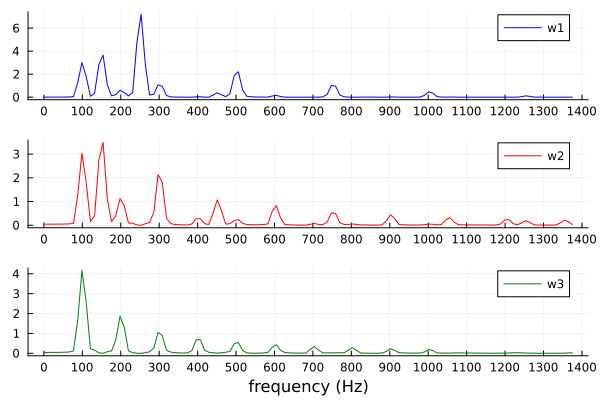

In [269]:
p1 = plot(freqs,W[:,1], color=:blue, label = "w1")
p2 = plot(freqs,W[:,2], color=:red, label = "w2")
p3 = plot(freqs,W[:,3], color=:green, label = "w3", xlabel = "frequency (Hz)")
plot(p1,p2,p3, layout=(k,1))
plot!(xticks=0:100:1400)

We will make a data set where each "song" uses the same three notes, but are played at random times.
The goal will be to learn the frequencies of these notes (the columns of W), given input-output pairs of (Y,H)

In [365]:
# Generate dataset of NN matricies W and H and their product V
#set seed
Random.seed!(314)

# V ∈ R^(m × n), and r is the (low) rank of V
m, n = size(Y)
r = 3
#true_W = abs.(randn((m, r)))

train_set_size = 20
test_set_size  = 5

notes = 100*[2,3,5]/2

function envelope(t, delay)
    ϵ = 0#1e-4 #prevent divide by zero errors
    a = @. exp(-(t - delay)) * (t .>= delay)
    return @. a + (ϵ * (t < delay))
end

function make_VH()
    delays = [rand()*(T-0.5) for _ ∈ notes] #avoid having a note start right at the end of the recording
    y = arp_chord(t,notes,delays)
    V = abs.(stft(y, window, hop))
    H = vcat([envelope(times, delay)' for delay ∈ delays]...)
    return (V,H)
end

train = [make_VH() for _ ∈ 1:train_set_size] #TODO turn this into generators
test  = [make_VH() for _ ∈ 1:test_set_size]
train_H = [H for (_, H) ∈ train]
train_V = [V for (V, _) ∈ train]
test_H = [H for (_, H) ∈ test]
test_V = [V for (V, _) ∈ test]
#test_H  = [abs.(randn((r, n))) for _ ∈ 1:test_set_size ]
#train_V = [true_W*train_H[i]   for i ∈ 1:train_set_size]
#test_V  = [true_W*test_H[i]    for i ∈ 1:test_set_size ]

# LATER can add small noise

5-element Vector{Matrix{Float64}}:
 [0.5706643496312199 0.002923599754855122 … 0.0003146631015560897 0.0007548181332022175; 0.5730288513331391 0.003143232320636673 … 0.0006881503565600177 0.0008303733037823523; … ; 1.5476386350396694 0.8994783122470998 … 4.603823063604257e-6 2.45863739591236e-6; 0.3929609300320366 0.06818170643358008 … 3.4959462178616833e-6 1.7577954092189552e-6]
 [0.0 0.0 … 0.002409728606734607 0.002280362504434086; 0.0 0.0 … 0.0026106421102591246 0.002461883975901367; … ; 0.0 0.0 … 0.0010141817627292427 0.0006938562618014479; 0.0 0.0 … 0.00013447393638498257 4.0745533750059806e-5]
 [0.37536664981189416 0.726326238527887 … 0.0035272885545689636 0.0002760195698557899; 0.3765493274496079 0.726326891625767 … 0.0037569847317964226 0.0006930989746742134; … ; 0.11820488907028706 0.22812527717654643 … 3.519929298261065e-5 2.4120924251413006e-5; 0.11773362035127664 0.22678780334060955 … 5.290982855441628e-6 3.3438704657863576e-6]
 [0.0 0.0 … 0.0001625334043720561 0.0030522055

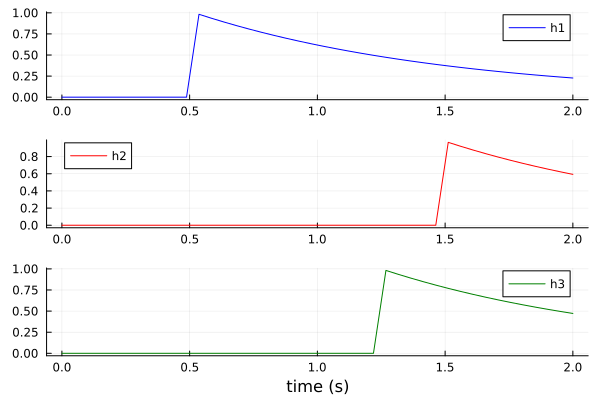

In [359]:
V, H = make_VH()
p1 = plot(times,H[1,:], color=:blue, label = "h1")
p2 = plot(times,H[2,:], color=:red, label = "h2")
p3 = plot(times,H[3,:], color=:green, label = "h3", xlabel = "time (s)")
plot(p1,p2,p3, layout=(k,1))

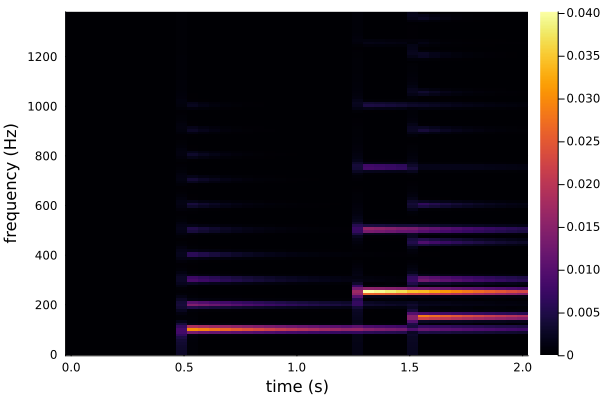

In [361]:
plotSTFT(V)

In [304]:
#wavplay(make_y(),sample_rate)

In [389]:
min(NaN,0)

NaN

In [411]:
# Define the model (copied from https://fluxml.ai/Flux.jl/stable/models/advanced/)
struct MyLayer
    W
end

W_init = abs.(randn((m,r))) #use the same random initialization
function MyLayer(m,r) # TODO add type stable-ness
    W = W_init # TODO adjust initialization
    MyLayer(W)
end

function (a::MyLayer)((H, V)) #must pass a single item into chains, that is why (H,V) are grouped
    W = a.W #force the matrix to be positive
    ϵ = 1e-6 #avoid divide by zero problems
    return (H .* (W'*V) ./ (W'*W*H .+ ϵ), V) #one update step
    # TODO can add regularization later
end
#Flux.trainable(a::MyLayer) = (a.W,) #Flux.trainable(a.W) #
Flux.@functor MyLayer (W,) #declare the weights W as trainable parameters

#function (a::MyLayer)(A::Matrix{Float64})

struct MyModel
    chain::Chain
end

H_guess = abs.(randn((r,n))) # same random guess for all inputs

# this is automatic from the struct
#function MyModel(chain::Chain)
#    MyModel(chain) 
#end

function (m::MyModel)(V::Matrix{Float64}, H_guess=H_guess)
    H_out, V_out = m.chain((H_guess, V)) #must pass a single item into chains
    return H_out #just care about the first entry
end

function (m::MyModel)(V::Vector{Matrix{Float64}}) #TODO update Float64 to something more general
    return m.(V) #apply m to all elements in V
end
  
# Call @functor to allow for training. Described below in more detail.
Flux.@functor MyModel

my_layer = MyLayer(m,r)
chain = Chain([my_layer for _ ∈ 1:20]) #20 layer network, each layer shares parameters
#chain = Chain([MyLayer(m,r) for _ ∈ 1:20]) #20 layer network, layers have different parameters
model = MyModel(chain)

MyModel(Chain([MyLayer([0.3441276649668956 0.9025348401298984 0.6356245379602533; 1.8582248155263725 0.5053320314325331 0.3913732459483644; … ; 0.4514701405973602 1.4595649203624177 2.0312543608147204; 0.4358243582609381 1.356711311909094 0.2509335564562955]), MyLayer([0.3441276649668956 0.9025348401298984 0.6356245379602533; 1.8582248155263725 0.5053320314325331 0.3913732459483644; … ; 0.4514701405973602 1.4595649203624177 2.0312543608147204; 0.4358243582609381 1.356711311909094 0.2509335564562955]), MyLayer([0.3441276649668956 0.9025348401298984 0.6356245379602533; 1.8582248155263725 0.5053320314325331 0.3913732459483644; … ; 0.4514701405973602 1.4595649203624177 2.0312543608147204; 0.4358243582609381 1.356711311909094 0.2509335564562955]), MyLayer([0.3441276649668956 0.9025348401298984 0.6356245379602533; 1.8582248155263725 0.5053320314325331 0.3913732459483644; … ; 0.4514701405973602 1.4595649203624177 2.0312543608147204; 0.4358243582609381 1.356711311909094 0.2509335564562955]), M

In [363]:
Flux.params(model)

Params([[1.3616445533923698 2.37131884078508 0.43721885667613336; 1.1504743289133406 1.441034085989755 1.4722168391851695; … ; 1.1548517419762243 0.46999071595142355 1.6875528441453298; 0.9631201042188658 0.11346222628095863 1.3117417261718687]])

In [6]:
chain

Chain([
  MyLayer([0.48085473104886106 1.036039482477762 … 0.010646341218065378 2.0469332331336973; 0.5580086101319748 1.5670824143010642 … 2.2695069644879435 0.9697242528666199; … ; 1.378127110188266 0.3028451974378638 … 0.41502359764137703 1.309556158412688; 0.9939912754884234 0.8486156790433032 … 0.3141829924409236 0.6265788705194885]),  # 75 parameters
  MyLayer([0.48085473104886106 1.036039482477762 … 0.010646341218065378 2.0469332331336973; 0.5580086101319748 1.5670824143010642 … 2.2695069644879435 0.9697242528666199; … ; 1.378127110188266 0.3028451974378638 … 0.41502359764137703 1.309556158412688; 0.9939912754884234 0.8486156790433032 … 0.3141829924409236 0.6265788705194885]),  # 75 parameters
  MyLayer([0.48085473104886106 1.036039482477762 … 0.010646341218065378 2.0469332331336973; 0.5580086101319748 1.5670824143010642 … 2.2695069644879435 0.9697242528666199; … ; 1.378127110188266 0.3028451974378638 … 0.41502359764137703 1.309556158412688; 0.9939912754884234 0.8486156790433032

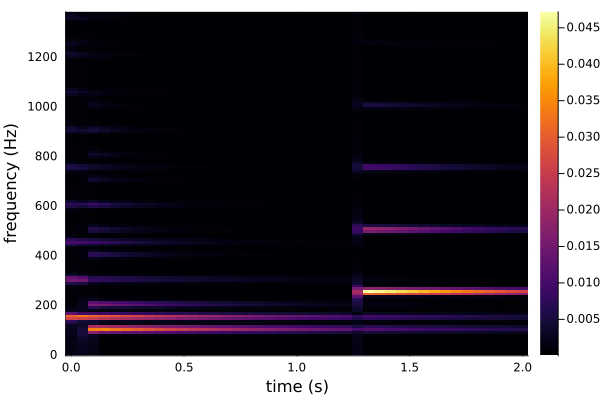

In [382]:
plotSTFT(train_V[7])

In [412]:
a = model(train_V)

20-element Vector{Matrix{Float64}}:
 [0.0 0.3725138943546155 … 0.12404686322474331 0.12837476942329248; 0.0 0.4385507173403011 … 2.3864536075651763e-6 2.982472824495583e-6; 0.0 0.275673166977928 … 0.35100939463806374 0.31925210264060416]
 [0.0 0.0 … 0.09511987790016976 0.11200098761987343; 0.0 0.0 … 0.0002777460047948752 0.00037440812097940684; 0.0 0.0 … 0.4953385233407774 0.44442162059717655]
 [0.0 0.0 … 0.12576759751043212 0.12630490294754282; 0.0 0.0 … 4.0212045970169254e-5 5.295462836422064e-5; 0.0 0.0 … 0.33145794502568515 0.30243048743589496]
 [0.0 0.0 … 0.1579237911747032 0.16841084388851382; 0.0 0.0 … 0.0061639083778692455 0.005882623842494315; 0.0 0.0 … 0.6084671960550513 0.544614984090026]
 [0.0 0.0 … 0.10889951643349952 0.11337329996451838; 0.0 0.0 … 0.06774825694998837 0.06050970879493137; 0.0 0.0 … 0.21171915212067005 0.1908228024803564]
 [0.0 0.37852188973450873 … 0.1535998738193702 0.153664515557391; 0.0 0.4492935567937481 … 4.535665256278295e-7 4.88080222459947e-7; 0.0 

In [370]:
[Flux.params(model)[1] * H for H ∈ train_H]

20-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 1.3951116759930757 1.312791021522509; 0.0 0.0 … 0.8387254493695991 0.7884651755393999; … ; 0.0 0.0 … 0.502773475392693 0.4724642480809365; 0.0 0.0 … 0.3961249395211832 0.3726341229904188]
 [0.0 0.0 … 1.5215116951337393 1.4490727789588629; 0.0 0.0 … 1.316651821323713 1.2539662493222545; … ; 0.0 0.0 … 0.8420992722825592 0.8020070674109832; 0.0 0.0 … 0.5026658079922723 0.47873397332705925]
 [0.0 0.0 … 0.964332277591466 0.9184205798736014; 0.0 0.0 … 0.8258708320961223 0.7865512605352687; … ; 0.0 0.0 … 0.5611912884885342 0.5344730655298084; 0.0 0.0 … 0.30922469866572927 0.29450256271535175]
 [0.0 0.0 … 1.9912797935407527 1.8964752971268455; 0.0 0.0 … 1.546035937737846 1.4724294264929263; … ; 0.0 0.0 … 0.9564355384657572 0.9108998031709299; 0.0 0.0 … 0.6304926447566941 0.6004749958694195]
 [0.0 0.0 … 1.5326776608116865 1.4597071348868862; 0.0 0.0 … 0.9369958835747952 0.8923856669832542; … ; 0.0 0.0 … 0.5086907908591805 0.48447210777193606; 0.0 

In [345]:
# Train the model
using Flux: mse
loss(model, V_input, H_truth) = mean(mse.(model(V_input), H_truth))
#loss(model, V_input, H_truth) = mean(mse.(model(V_input), H_truth) .+ mse.([Flux.params(model)[1] * H for H ∈ H_truth], V_input))
#loss(model, V_input, H_truth) = mean(mse(model(V_input), H_truth), mse(Flux.params(model)[1] * H_truth, V_input))
# mean squared error
                                                                    # the outer mean is to handle batches
# TODO idealy the model can be applied on batches without needing the elementwise application dot here
# second term fits the reconstructed V to the input
#loss(model, train_V, train_H)

using Flux: train!

opt = Descent() #or Adam(), see https://fluxml.ai/Flux.jl/stable/training/optimisers/ for full list

Descent(0.1)

In [10]:
typeof(data)

UndefVarError: UndefVarError: data not defined

In [11]:
#using Debugger

In [392]:
data = zip(train_V, train_H)
train!(loss, model, data, opt)  #warning: trainable(x) should now return a NamedTuple with the field names, not a Tuple

In [413]:
maxit = 500
training_loss = zeros(1,maxit)
testing_loss  = zeros(1,maxit)
for i ∈ 1:maxit
    train!(loss, model, data, opt)
    training_loss[i] = loss(model, train_V, train_H)
    testing_loss[i]  = loss(model, test_V , test_H )
end

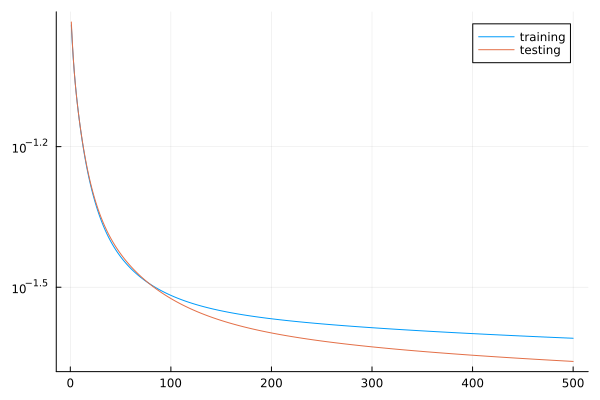

In [416]:
# Evaluate the model performance on the training and testing set
plot(1:maxit,[training_loss',testing_loss'],label=["training" "testing"],yscale=:log10)

In [399]:
Flux.params(model)[1]

126×3 Matrix{Float64}:
 -0.0830672  0.386706  0.914256
  0.342631   0.2419    0.0799464
  0.419199   0.395657  0.150331
  1.00108    0.577101  2.51978
  0.122267   0.710194  0.860857
  0.448838   0.287262  0.585043
  0.994711   1.1087    1.41769
  1.41822    0.381572  0.797518
  0.742941   0.164405  1.15756
  2.1278     1.10407   0.990804
  ⋮                    
  0.443288   0.111857  0.708628
  0.787118   0.564758  0.189575
  1.14911    1.6496    1.81604
  1.00778    0.676124  0.791334
 -0.0904252  0.785435  0.790595
 -0.0161046  2.35844   0.217718
  0.839051   0.472999  0.934659
  0.150454   1.25146   0.0492499
 -0.0681547  1.62177   0.886453

In [400]:
plot_compare(estimated, truth) = heatmap(abs.(estimated - truth))

plot_compare (generic function with 1 method)

In [43]:
#mean(abs.(Flux.params(model)[i]) for i ∈ 1:20) #ensure W is postive, since the positive version is used in the model


15×5 Matrix{Float64}:
 0.985746  0.877064  0.57892   0.931306  0.794096
 0.792048  0.737424  1.01251   0.634169  0.961405
 0.549876  0.742551  0.845197  0.760113  0.528839
 0.914668  0.627042  0.8969    0.651244  0.543206
 0.694089  0.565908  0.954593  0.87035   0.457627
 0.700581  1.27059   0.99777   0.637005  0.600312
 1.16263   0.97564   0.524253  0.730731  0.532368
 0.854088  0.499324  0.798802  0.453476  0.483474
 0.83387   0.457202  0.721732  0.741288  0.968904
 0.669034  0.623303  0.737103  0.746937  0.968621
 0.58992   0.750934  0.534702  0.425541  0.98808
 0.735896  0.803982  0.48359   0.96471   0.997608
 0.619934  0.448292  0.945782  0.918223  1.18227
 0.80976   1.05069   0.70826   0.901969  0.921649
 0.939035  0.866994  0.85392   0.709538  0.622632

In [401]:
learned_W = abs.(Flux.params(model)[1]) #ensure W is postive, since the positive version is used in the model

126×3 Matrix{Float64}:
 0.0830672  0.386706  0.914256
 0.342631   0.2419    0.0799464
 0.419199   0.395657  0.150331
 1.00108    0.577101  2.51978
 0.122267   0.710194  0.860857
 0.448838   0.287262  0.585043
 0.994711   1.1087    1.41769
 1.41822    0.381572  0.797518
 0.742941   0.164405  1.15756
 2.1278     1.10407   0.990804
 ⋮                    
 0.443288   0.111857  0.708628
 0.787118   0.564758  0.189575
 1.14911    1.6496    1.81604
 1.00778    0.676124  0.791334
 0.0904252  0.785435  0.790595
 0.0161046  2.35844   0.217718
 0.839051   0.472999  0.934659
 0.150454   1.25146   0.0492499
 0.0681547  1.62177   0.886453

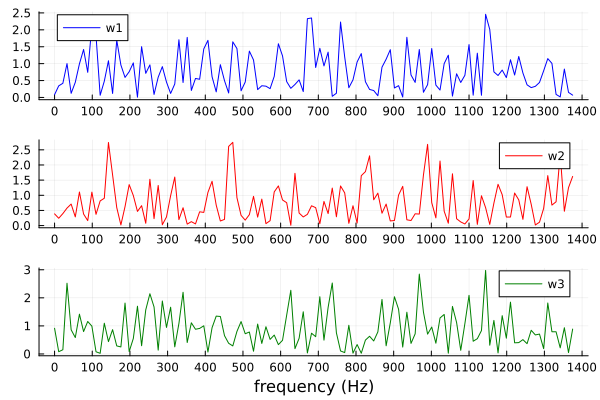

In [402]:
p1 = plot(freqs,learned_W[:,1], color=:blue, label = "w1")
p2 = plot(freqs,learned_W[:,2], color=:red, label = "w2")
p3 = plot(freqs,learned_W[:,3], color=:green, label = "w3", xlabel = "frequency (Hz)")
plot(p1,p2,p3, layout=(k,1))
plot!(xticks=0:100:1400)

In [417]:
# Observe how close the learned weights ̂W and the true W are
learned_W = abs.(Flux.params(model)[1]) #ensure W is postive, since the positive version is used in the model
#plot_compare(learned_W, true_W)

126×3 Matrix{Float64}:
 0.21443    0.837296    0.602271
 1.70114    0.397468    0.348348
 1.99923    0.464593    0.848277
 1.55596    0.218962    0.248357
 0.0663967  0.492417    0.0761962
 1.41472    0.641821    1.00709
 0.299068   0.270372    0.655193
 0.924514   0.91927     1.21702
 0.929173   1.13238     2.13146
 2.40761    0.597268    0.152026
 ⋮                      
 0.448366   0.234236    0.306768
 0.0244743  1.26813     1.82775
 0.274088   0.00351442  0.218484
 0.0469138  1.09987     1.26206
 0.564738   1.12563     1.32359
 0.898639   0.659767    0.436654
 1.1239     0.0564604   0.317229
 0.34136    1.33149     2.18265
 0.349295   1.33401     0.189633

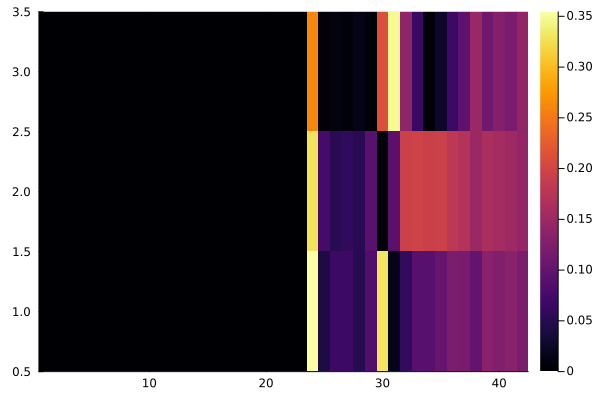

In [419]:
i = 4
plot_compare(model(train_V[i]), train_H[i]) # compare the model's prediction of H given V to the true H

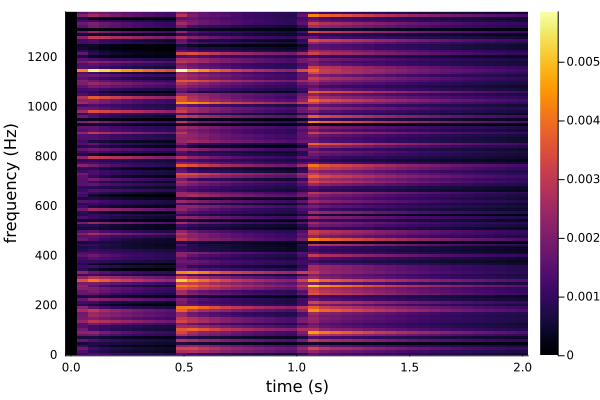

In [420]:
reconstructed_V = learned_W * model(train_V[1])
plotSTFT(reconstructed_V)
#plot_compare(reconstructed_V, train_V[1])

In [53]:
true_W

15×5 Matrix{Float64}:
 0.717232   1.13746    0.386419   1.21616    1.18876
 0.687969   0.157206   1.17731    0.659414   1.37251
 1.04901    1.47096    0.820954   1.16888    0.606793
 1.00867    0.0664747  1.75046    0.293182   0.22808
 0.0819987  0.278461   1.12093    1.13143    0.398515
 0.446776   1.74642    0.700761   0.0342518  0.0823133
 1.68286    1.35994    0.0262437  0.0754161  0.00377845
 2.74017    1.16615    1.10741    0.703545   0.258038
 0.85524    0.0865863  0.769343   0.327072   0.870381
 0.375762   0.512875   0.497433   0.685774   1.0771
 0.135264   1.24237    0.0753749  0.0157251  1.91956
 0.0130592  0.358328   0.299779   0.856369   1.79208
 0.405988   0.444948   0.419685   0.457245   1.84462
 0.0444676  0.622222   0.720983   0.258081   0.0786767
 0.521828   1.3334     0.838741   0.706235   1.24056

In [93]:
learned_W

15×5 Matrix{Float64}:
 1.10737    1.11509    0.425374  0.9223      0.443687
 0.0289605  0.613499   0.689856  0.189551    0.717106
 0.234583   0.452565   0.186438  0.358699    0.171964
 0.89227    0.0747493  1.49239   0.0646355   0.0668132
 0.936021   0.671893   0.475682  0.570726    0.254381
 0.228246   1.50963    0.58043   0.125543    0.0801775
 1.04903    1.038      0.231205  0.00263955  0.32092
 0.837416   0.409548   0.272294  0.317537    0.811106
 0.911392   0.168482   0.805044  0.320756    0.947743
 0.101127   0.640546   0.188954  0.625116    1.74287
 0.482056   0.474347   0.618978  0.672204    0.724253
 0.165401   0.460973   0.30516   0.740111    1.65128
 0.172865   0.0980154  0.24617   0.209687    1.39943
 0.0600203  0.944991   0.870339  0.468817    0.814745
 0.371466   0.334945   0.184978  0.0546923   0.289995

In [56]:
model(train_V[1])

5×15 Matrix{Float64}:
 0.421083   0.794472  0.337686  0.318859   …  0.544368   0.0802001  0.0431037
 0.412838   0.350639  0.390473  0.0852996     0.349363   1.14901    0.563882
 0.777139   0.266403  0.744462  0.0252331     0.628381   0.0405921  0.119422
 0.854712   0.621507  1.26382   0.0419388     0.0650061  1.07083    0.452879
 0.0945917  0.673582  2.25862   0.694953      0.195706   0.832013   0.697999

In [57]:
train_H[1]

5×15 Matrix{Float64}:
 0.417054   0.791355  0.329537  0.321316   …  0.543201   0.0821013  0.0473063
 0.413354   0.354055  0.397168  0.085302      0.352863   1.14585    0.561299
 0.779789   0.269077  0.751811  0.0192033     0.633719   0.0212175  0.113677
 0.847775   0.618984  1.25798   0.0397027     0.0484056  1.0779     0.460959
 0.0902536  0.672425  2.25557   0.697806      0.199252   0.831676   0.697721

In [58]:
train_V[1]

15×15 Matrix{Float64}:
 2.20894   2.62642   5.18987  1.21271   …  1.33158   3.67001   2.10633
 1.95286   2.24795   5.09957  1.241        1.48065   2.11386   1.51621
 2.7314    2.70338   4.3862   0.948137     1.78661   3.55363   1.93077
 2.08227   1.6276    2.55808  0.534182     1.7403    0.701834  0.578297
 2.01856   1.43341   3.30255  0.394634     0.987326  1.9006    1.0872
 1.49113   1.237     1.59644  0.364785  …  1.32108   2.15807   1.15428
 1.34872   1.86951   1.21781  0.662869     1.41503   1.78144   0.883324
 3.10812   3.48831   3.66578  1.2092       2.68721   2.55766   1.41442
 1.34824   1.70219   3.26928  0.917305     1.17192   1.26218   0.934566
 1.4352    1.76155   3.99366  0.952872     0.94813   2.26408   1.42983
 0.815307  1.86768   4.94415  1.49099   …  0.942865  3.04968   2.05887
 1.27508   1.95299   5.49145  1.32504      0.722038  2.83154   1.88095
 1.23463   2.11514   5.36189  1.4818       1.03318   2.57907   1.81446
 1.06385   0.662143  1.30595  0.146358     0.728783 

In [59]:
learned_W * model(train_V[1])

15×15 Matrix{Float64}:
 1.15313   1.03361   1.45371   0.357855  …  0.962905  0.675863  0.436153
 0.703168  0.519167  0.979253  0.167638     0.530397  0.972692  0.543936
 0.580299  0.781943  1.98637   0.47884      0.375748  1.21965   0.767229
 1.21041   0.974981  2.20635   0.380371     0.773312  1.50296   0.888793
 1.81099   1.72245   3.63725   0.695126     0.996987  1.82826   1.10183
 1.1655    0.983114  1.75181   0.358892  …  0.918961  1.91717   1.05887
 1.21377   1.65054   1.82076   0.714892     1.2608    1.78485   0.997659
 1.10044   1.96858   2.32365   1.01801      1.29965   1.01237   0.70653
 1.31822   1.47118   3.17859   0.793042     1.06943   1.56764   1.06843
 0.608055  1.09009   2.83771   0.747791     0.391242  1.62597   1.05024
 0.857271  1.77894   4.73563   1.37687   …  0.864467  2.82546   1.90674
 1.549     2.05988   4.25003   1.10314      1.09206   2.5144    1.55742
 0.916174  1.39087   2.88348   0.844754     0.830163  1.61191   1.06854
 1.32732   0.941886  1.59407   0.253

In [60]:
true_W * model(train_V[1])

15×15 Matrix{Float64}:
 2.22382   2.62818  5.19598  1.21261   …  1.34235   3.67152   2.09898
 1.96296   2.24966  5.10351  1.24396      1.4807    2.13166   1.51554
 2.74343   2.70308  4.38754  0.951389     1.79556   3.56412   1.9256
 2.08469   1.62684  2.5554   0.542263     1.73596   0.732043  0.581981
 2.02535   1.43303  3.30093  0.402584     0.997834  1.91517   1.08498
 1.49077   1.23073  1.58369  0.36775   …  1.31203   2.17609   1.16068
 1.35527   1.87024  1.22268  0.659047     1.41334   1.78251   0.879306
 3.12162   3.49197  3.67706  1.20997      2.69118   2.5727    1.40666
 1.35564   1.70433  3.27458  0.918091     1.17086   1.27371   0.933214
 1.44456   1.76261  3.99692  0.953408     0.951684  2.27013   1.42719
 0.823447  1.86592  4.94233  1.48567   …  0.931727  3.05534   2.06235
 1.28787   1.95523  5.49743  1.32362      0.727061  2.833     1.87712
 1.2461    2.11705  5.36744  1.47909      1.0309    2.58522   1.81313
 1.06393   0.65897  1.29859  0.150947     0.726815  1.08959   0.6

In [61]:
learned_W * train_H[1]

15×15 Matrix{Float64}:
 1.15056   1.03366   1.45377   0.354849  …  0.964137  0.663021  0.435589
 0.703051  0.521834  0.985032  0.165422     0.533224  0.963777  0.541084
 0.576081  0.781968  1.98591   0.479137     0.375073  1.2176    0.767821
 1.20752   0.977051  2.21102   0.376551     0.773069  1.49095   0.887042
 1.80113   1.71999   3.63172   0.691028     0.986281  1.82027   1.10714
 1.16472   0.987796  1.76146   0.356452  …  0.924352  1.90423   1.05433
 1.20861   1.65111   1.81967   0.717324     1.26552   1.77908   0.998346
 1.09127   1.96391   2.31094   1.0226       1.30147   1.0104    0.71187
 1.3129    1.47151   3.17904   0.791098     1.07232   1.55388   1.06705
 0.600998  1.0889    2.8341    0.749906     0.389411  1.62739   1.05256
 0.848962  1.77999   4.73619   1.38122   …  0.87271   2.82037   1.90447
 1.53783   2.05794   4.24417   1.10414      1.08798   2.51077   1.56168
 0.9099    1.39032   2.88112   0.846285     0.832785  1.60656   1.06899
 1.32637   0.944702  1.60049   0.248